In [10]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
train_path = "Data/train"
val_path = "Data/valid"
test_path = "Data/test"

In [11]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


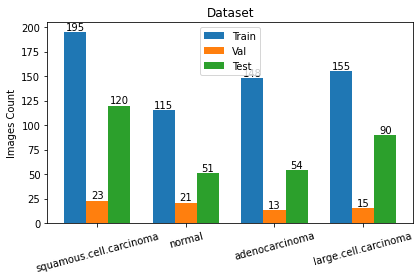

In [12]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()
plt.show()

In [13]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [14]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [15]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [16]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [17]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [18]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [19]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [20]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet", 
                      pooling='max')

94781440/94765736 [==============================] - 9s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [23]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [24]:
mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [25]:
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.6968 - accuracy: 0.3783
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 52s 412ms/step - loss: 1.6968 - accuracy: 0.3783 - val_loss: 1.2738 - val_accuracy: 0.4286
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.4424
Epoch 2: val_accuracy did not improve from 0.42857
122/122 [==============================] - 49s 400ms/step - loss: 1.2291 - accuracy: 0.4424 - val_loss: 1.1034 - val_accuracy: 0.4286
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.1956 - accuracy: 0.4030
Epoch 3: val_accuracy improved from 0.42857 to 0.50000, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 49s 403ms/step - loss: 1.1956 - accuracy: 0.4030 - val_loss: 1.0916 - val_accuracy: 0.5000
Epoch 4/32
122/122 [==============================] - ETA: 0s 

In [26]:
model = load_model("./ct_resnet_best_model.hdf5")

In [27]:
accuracy_resnet = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_resnet*100} %")

The accuracy of the model is = 51.74603462219238 %


In [28]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(350,350))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [40]:
path = "Data/test/adenocarcinoma/000121.png"
chestScanPrediction(path,model_resnet)

Adenocarcinoma
